In [18]:
pip install mlxtend

/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=59471) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [23]:
df = pd.read_csv('Final_dataset.csv')
selected_columns = ['Country', 'Vendor INCO Term', 'Shipment Mode', 'Vendor', 
                    'First Line Designation', 'Manufacturing country']
df_cat = df[selected_columns]
transactions = df_cat.apply(lambda row: [f"{col}_{row[col].strip()}" for col in df_cat.columns], axis=1).tolist()
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)
df_encoded
df_encoded.to_csv('ARM_dataset.csv', index=False)


In [15]:
frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)
min_lift_threshold = 1    
min_confidence_threshold = 0.6  
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=min_lift_threshold)
rules = rules[rules['confidence'] >= min_confidence_threshold]
top_15_support = rules.sort_values(by='support', ascending=False).head(15)
top_15_confidence = rules.sort_values(by='confidence', ascending=False).head(15)
top_15_lift = rules.sort_values(by='lift', ascending=False).head(15)
print("\nTop 15 Rules by Support:")
print(top_15_support)
print("\nTop 15 Rules by Confidence:")
print(top_15_confidence)
print("\nTop 15 Rules by Lift:")
print(top_15_lift)


Top 15 Rules by Support:
                                           antecedents  \
98                   (Vendor INCO Term_N/A - From RDC)   
99                              (Vendor_SCMS from RDC)   
77                              (Vendor_SCMS from RDC)   
72                   (Vendor INCO Term_N/A - From RDC)   
430  (Vendor INCO Term_N/A - From RDC, Manufacturin...   
431  (Vendor INCO Term_N/A - From RDC, Vendor_SCMS ...   
435                             (Vendor_SCMS from RDC)   
433                  (Vendor INCO Term_N/A - From RDC)   
432  (Manufacturing country_India, Vendor_SCMS from...   
59                                 (Shipment Mode_Air)   
58                        (First Line Designation_Yes)   
333   (Manufacturing country_India, Shipment Mode_Air)   
332  (Manufacturing country_India, First Line Desig...   
375                             (Vendor_SCMS from RDC)   
373  (Vendor_SCMS from RDC, First Line Designation_...   

                                           co

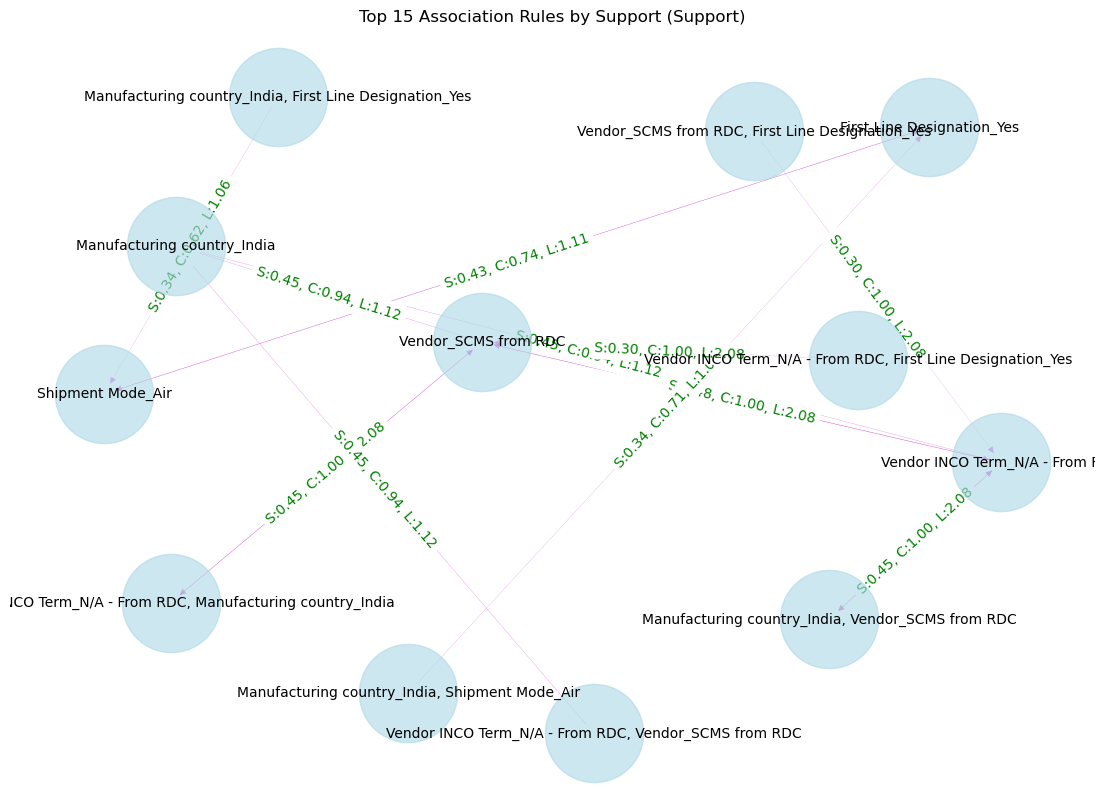

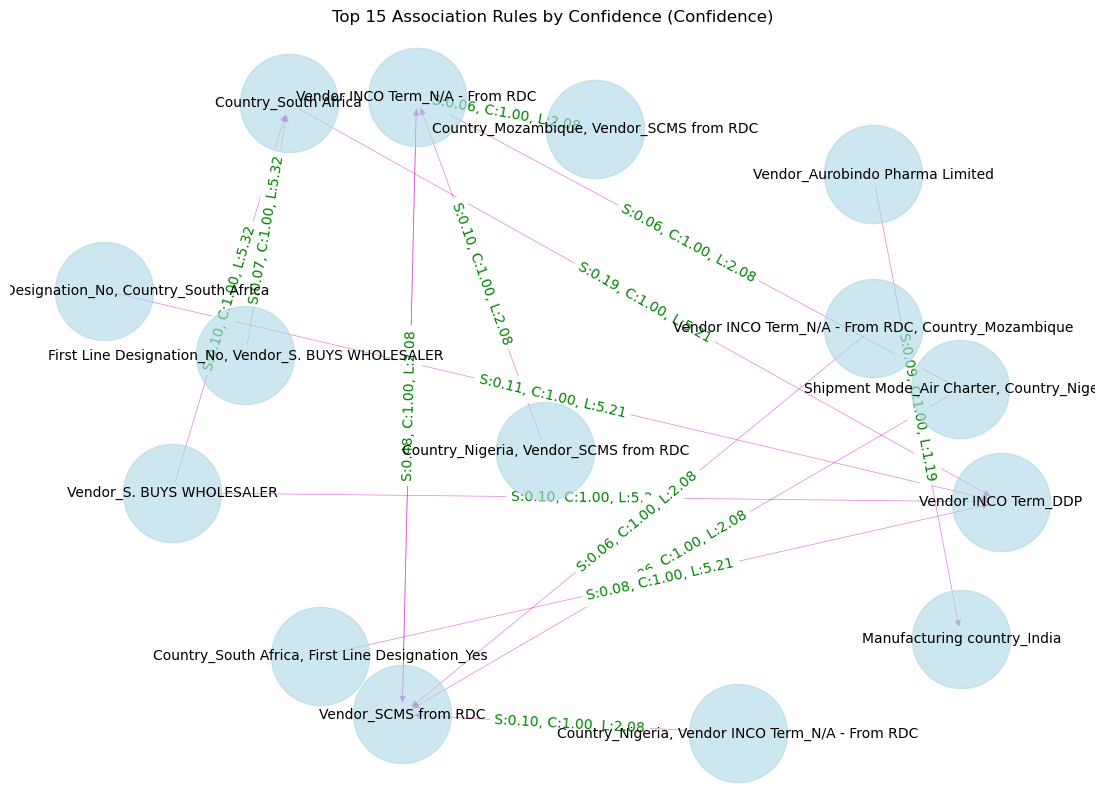

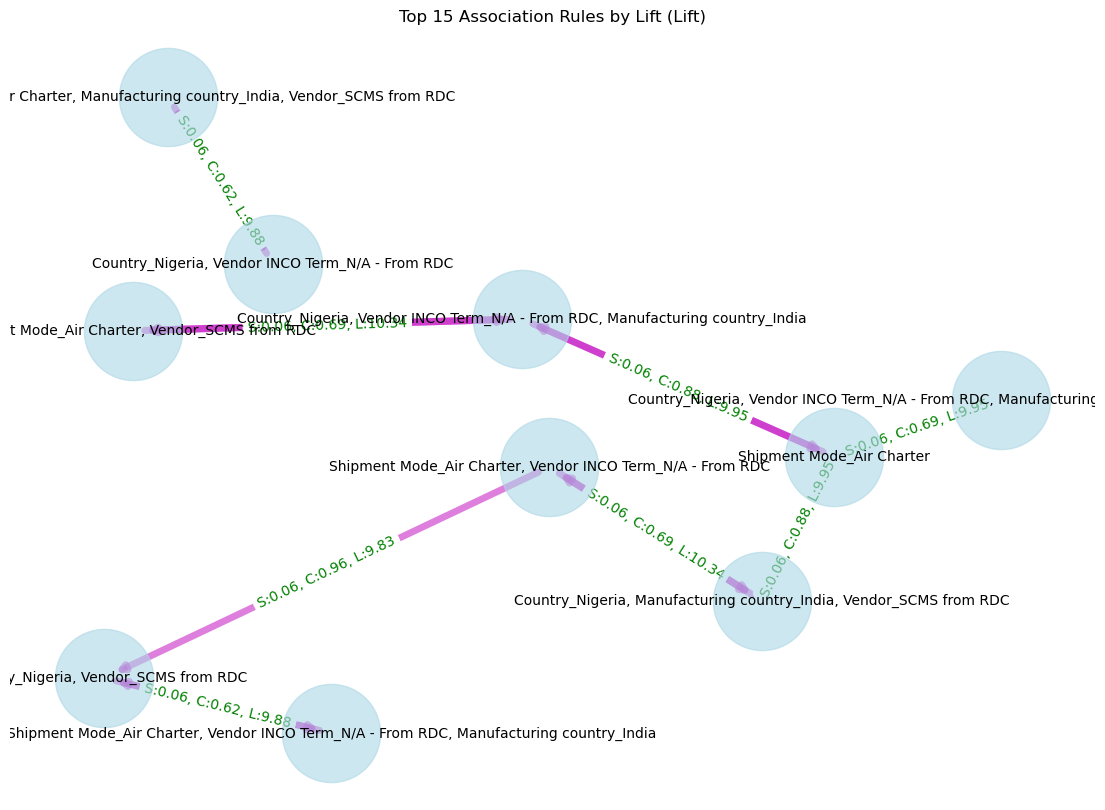

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

def draw_network_graph(rules, metric='lift', top_n=15, title_suffix=''):
    selected_rules = rules.nlargest(top_n, metric)
    
    plt.figure(figsize=(14, 10))
    G = nx.DiGraph()
    
    for _, row in selected_rules.iterrows():
        antecedents = ', '.join(list(row['antecedents']))
        consequents = ', '.join(list(row['consequents']))
        G.add_edge(antecedents, consequents, 
                   weight=row[metric], 
                   support=row['support'], 
                   confidence=row['confidence'], 
                   lift=row['lift'])

    pos = nx.spring_layout(G, k=1, iterations=20)
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=5000, alpha=0.6)
    edge_widths = [G[u][v]['weight']*0.5 for u, v in G.edges()]  # Scale edge width
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='m')
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    edge_labels = dict([((u, v,), f"S:{d['support']:.2f}, C:{d['confidence']:.2f}, L:{d['lift']:.2f}")
                        for u, v, d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')
    
    plt.title(f'Top {top_n} Association Rules by {metric.capitalize()} {title_suffix}')
    plt.axis('off')
    plt.show()

draw_network_graph(rules, metric='support', top_n=15, title_suffix='(Support)')

draw_network_graph(rules, metric='confidence', top_n=15, title_suffix='(Confidence)')

draw_network_graph(rules, metric='lift', top_n=15, title_suffix='(Lift)')

